# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.833350,False,-5.537440
1,0.112280,True,3.618443
2,-0.917444,False,-0.093863
3,0.478427,True,5.187700
4,1.536326,True,8.979689
...,...,...,...
995,0.613221,True,7.049463
996,0.732101,True,6.793848
997,0.853697,True,6.377998
998,-0.988448,False,-1.282949


<AxesSubplot: xlabel='v0'>

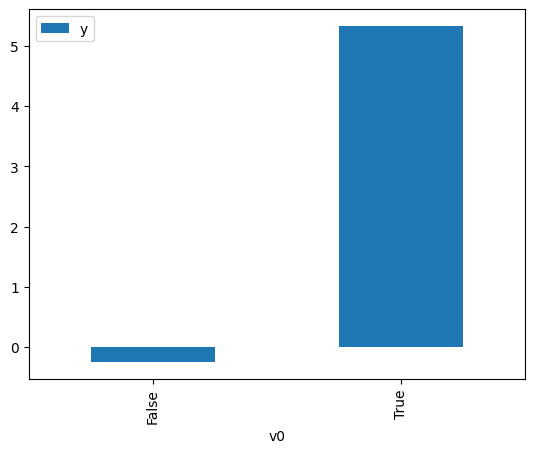

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

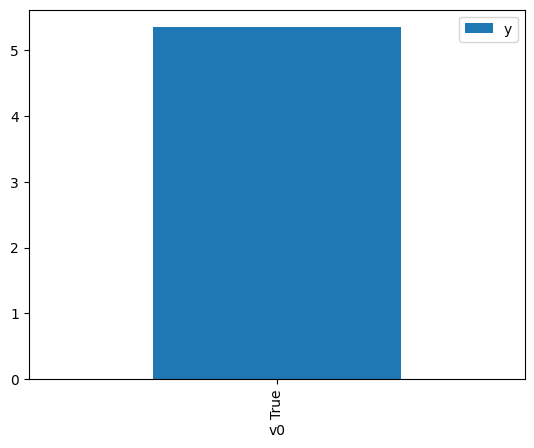

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.661972,False,2.216604,0.178661,5.597193
1,-0.005500,False,0.548451,0.479988,2.083383
2,-0.311026,False,-0.224046,0.641414,1.559057
3,0.212942,False,1.019415,0.365144,2.738647
4,-1.018286,False,-3.171550,0.892162,1.120872
...,...,...,...,...,...
995,-1.107272,False,-2.029394,0.909349,1.099688
996,-1.526499,False,-2.918669,0.961340,1.040215
997,-1.365184,False,-2.502406,0.946048,1.057029
998,-0.706887,False,-1.809956,0.808255,1.237234


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.607460,True,5.762749,0.803356,1.244778
1,0.901764,True,6.310603,0.885411,1.129419
2,-0.554129,True,3.487074,0.248258,4.028067
3,2.255206,True,9.941129,0.993142,1.006905
4,1.338642,True,9.145532,0.952153,1.050251
...,...,...,...,...,...
995,0.096872,True,7.112118,0.574874,1.739510
996,-0.850068,True,3.669570,0.148204,6.747452
997,-0.797255,True,4.464058,0.163229,6.126353
998,-0.000676,True,5.992398,0.522618,1.913443


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.087e+04
Date:                Sat, 03 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:28:52   Log-Likelihood:                         -1458.0
No. Observations:                1000   AIC:                                      2920.
Df Residuals:                     998   BIC:                                      2930.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7974      0.036     50.120      0.000       1.727       1.868
x2             5.0578      0.051     98.486      0.000       4.957       5.159
==============================================================================
Omnibus:                        0.479   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.373
Skew:                          -0.033   Prob(JB):                        0.830
Kurtosis:                       3.069   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""